# Computing characteristic speeds

We start from a hyperbolic conservation law, restricted to one normal direction that we will call $x$, written as
$$
  \partial_t {\bf q} + \partial_x {\bf f}({\bf q}) = {\bf 0}.
$$
The characteristic speeds are the eigenvalues of the Jacobian matrix
$$
  J = \frac{\partial {\bf f}}{\partial {\bf q}}.
$$
They are directly relevant for the development of the numerical methods. In particular, they set the maximum timestep through the CFL limit.

We will compute the eigenvalues *numerically* for some systems using automatic differentiation.

## Modules

In [1]:
import jax
from jax import numpy as np
from matplotlib import pyplot

In [2]:
%matplotlib inline

## Advection

The simplest case:
$$
\begin{aligned}
  {\bf q} &= q \\ {\bf f} &= v q \\ v &= 1, \text{constant}.
\end{aligned}
$$

In [3]:
def flux_advection(q):
    return q

In [45]:
J_advection = jax.jacfwd(flux_advection)

In [46]:
J_advection(1.0)

array(1.)

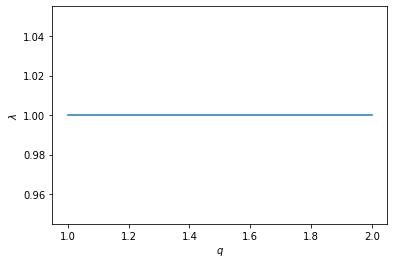

In [47]:
qs = np.linspace(1, 2)
evals = []
for q in qs:
    evals.append(J_advection(q))
pyplot.plot(qs, evals)
pyplot.xlabel(r'$q$')
pyplot.ylabel(r'$\lambda$')
pyplot.show()

## Burgers

Still a scalar problem.
$$
\begin{aligned}
  {\bf q} &= q \\ {\bf f} &= \tfrac{1}{2} q^2.
\end{aligned}
$$

In [12]:
def flux_burgers(q):
    return 0.5 * q**2

In [48]:
J_burgers = jax.jacfwd(flux_burgers)

In [49]:
J_burgers(1.5)

DeviceArray(1.5, dtype=float32)

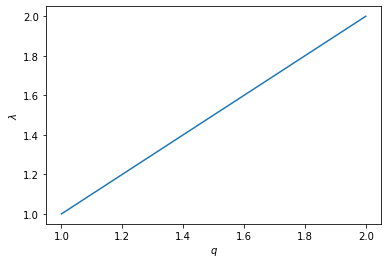

In [50]:
qs = np.linspace(1, 2)
evals = []
for q in qs:
    evals.append(J_burgers(q))
pyplot.plot(qs, evals)
pyplot.xlabel(r'$q$')
pyplot.ylabel(r'$\lambda$')
pyplot.show()

## Shallow water

A $2 \times 2$ system:
$$
\begin{aligned}
  {\bf q} &= \begin{pmatrix} \phi \\ \phi u \end{pmatrix} \\ {\bf f} &= \begin{pmatrix} \phi u \\ \phi u^2 + \tfrac{1}{2} \phi^2 \end{pmatrix}.
\end{aligned}
$$

In [51]:
def flux_sw(q):
    phi, phi_u = q
    u = phi_u / phi
    return np.array([phi_u, phi_u * u + 0.5 * phi**2])

In [52]:
J_sw = jax.jacfwd(flux_sw)

In [53]:
J_sw([1.0, 1.0])

[DeviceArray([0., 0.], dtype=float32), DeviceArray([1., 2.], dtype=float32)]

In [54]:
np.linalg.eigvals(J_sw([1.0, 1.0]))

DeviceArray([2.+0.j, 0.+0.j], dtype=complex64)

/Users/ih3/anaconda3/envs/icts/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ih3/anaconda3/envs/icts/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


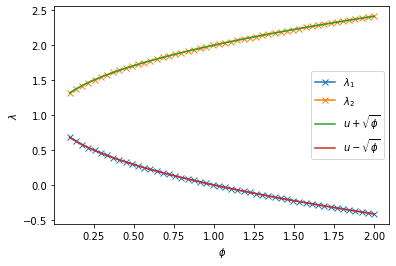

In [55]:
phis = np.linspace(0.1, 2)
evals = []
for phi in phis:
    evals.append(np.linalg.eigvals(J_sw([phi, phi*1])))
pyplot.plot(phis, np.array(evals)[:,0], '-x', label=r"$\lambda_1$")
pyplot.plot(phis, np.array(evals)[:,1], '-x', label=r"$\lambda_2$")
pyplot.plot(phis, np.sqrt(phis)+1, label=r"$u + \sqrt{\phi}$")
pyplot.plot(phis,-np.sqrt(phis)+1, label=r"$u - \sqrt{\phi}$")
pyplot.xlabel(r'$\phi$')
pyplot.ylabel(r'$\lambda$')
pyplot.legend()
pyplot.show()

## Newtonian Euler equations

A $3 \times 3$ system, using the simplified EOS $p = (\gamma - 1) \rho \epsilon$ with $\gamma = 5/3$:
$$
\begin{aligned}
  {\bf q} &= \begin{pmatrix} \rho \\ \rho u \\ \rho (\epsilon + u^2 / 2) \end{pmatrix} \\ {\bf f} &= \begin{pmatrix} \rho u \\ \rho u^2 + p \\ ( \rho (\epsilon + u^2 / 2) + p) u \end{pmatrix}.
\end{aligned}
$$

In [61]:
def p(rho, epsilon):
    return 2 * rho * epsilon / 3

def flux_euler(q):
    rho, S, E = q
    u = S / rho
    epsilon = (E - S * u / 2) / rho
    return np.array([S, S*u + p(rho, epsilon), (E + p(rho, epsilon)) * u])

In [62]:
J_euler = jax.jacfwd(flux_euler)

/Users/ih3/anaconda3/envs/icts/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ih3/anaconda3/envs/icts/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ih3/anaconda3/envs/icts/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


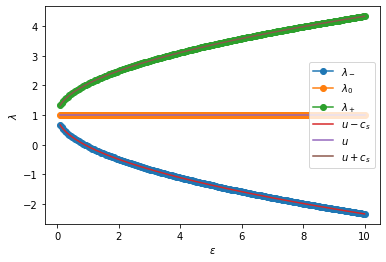

In [67]:
u = 1.0
rho = 1.0
epss = np.linspace(0.1, 10, 200)
cs = np.sqrt(5/3*p(rho, epss)/rho)
evals = []
for epsilon in epss:
    evals.append(np.linalg.eigvals(J_euler([rho, rho*u, rho*(epsilon + u**2 / 2)])))
pyplot.plot(epss, np.array(evals)[:,0], '-o', label=r"$\lambda_-$")
pyplot.plot(epss, np.array(evals)[:,1], '-o', label=r"$\lambda_0$")
pyplot.plot(epss, np.array(evals)[:,2], '-o', label=r"$\lambda_+$")
pyplot.plot(epss, u-cs, label=r"$u - c_s$")
pyplot.plot(epss, u*np.ones_like(rhos), label=r"$u$")
pyplot.plot(epss, u+cs, label=r"$u + c_s$")
pyplot.xlabel(r'$\epsilon$')
pyplot.ylabel(r'$\lambda$')
pyplot.legend()
fig.tight_layout()
pyplot.show()